<a href="https://colab.research.google.com/github/Lasttrader/Neural_networks_computer_vision/blob/master/nn_cnn_vgg16_cats_and_dogs_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## VGG16 для распознавания котов и собак


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline 

## Устанавливаем API Kaggle

In [0]:
!pip install kaggle

Загружаем токен для аутентификации

In [0]:
file = files.upload()

Копируем токен в каталог .kaggle

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

Загружаем данные с сайта Kaggle

In [0]:
!kaggle competitions download -c nu-cats-and-dogs-spring2019

 99% 107M/108M [00:00<00:00, 101MB/s]  
100% 108M/108M [00:00<00:00, 161MB/s]
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
 41% 9.00M/22.1M [00:00<00:00, 81.2MB/s]
100% 22.1M/22.1M [00:00<00:00, 108MB/s] 


In [0]:
!ls

cats_and_dogs  sample_submission.csv  test_full  train_full  val_full
sample_data    test		      test.zip	 train.zip


In [0]:
!head sample_submission.csv

filename,label
0.jpg,0
1.jpg,0
2.jpg,0
3.jpg,0
4.jpg,0
5.jpg,0
6.jpg,0
7.jpg,0
8.jpg,0


In [0]:
!unzip -q train.zip

In [0]:
!ls train

cats  dogs


In [0]:
!unzip -q test.zip

In [0]:
!ls test

0.jpg	 200.jpg  301.jpg  402.jpg  503.jpg  604.jpg  705.jpg  806.jpg	907.jpg
100.jpg  201.jpg  302.jpg  403.jpg  504.jpg  605.jpg  706.jpg  807.jpg	908.jpg
101.jpg  202.jpg  303.jpg  404.jpg  505.jpg  606.jpg  707.jpg  808.jpg	909.jpg
102.jpg  203.jpg  304.jpg  405.jpg  506.jpg  607.jpg  708.jpg  809.jpg	90.jpg
103.jpg  204.jpg  305.jpg  406.jpg  507.jpg  608.jpg  709.jpg  80.jpg	910.jpg
104.jpg  205.jpg  306.jpg  407.jpg  508.jpg  609.jpg  70.jpg   810.jpg	911.jpg
105.jpg  206.jpg  307.jpg  408.jpg  509.jpg  60.jpg   710.jpg  811.jpg	912.jpg
106.jpg  207.jpg  308.jpg  409.jpg  50.jpg   610.jpg  711.jpg  812.jpg	913.jpg
107.jpg  208.jpg  309.jpg  40.jpg   510.jpg  611.jpg  712.jpg  813.jpg	914.jpg
108.jpg  209.jpg  30.jpg   410.jpg  511.jpg  612.jpg  713.jpg  814.jpg	915.jpg
109.jpg  20.jpg   310.jpg  411.jpg  512.jpg  613.jpg  714.jpg  815.jpg	916.jpg
10.jpg	 210.jpg  311.jpg  412.jpg  513.jpg  614.jpg  715.jpg  816.jpg	917.jpg
110.jpg  211.jpg  312.jpg  413.jpg  514.jpg  615.jpg  716

Смотрим примеры картинок

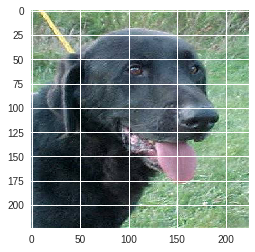

In [0]:
img_path = 'test/2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

## Создаем генератор изображений

In [0]:
# Каталог с данными для обучения
train_dir = 'train'
# Размеры изображения
img_width, img_height = 224, 224
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Размер мини-выборки
batch_size = 50
# Количество элементов данных для обучения
nb_train_samples = 5000

Генератор изображений создается на основе класса ImageDataGenerator с дополнением данных.

In [0]:
datagen = ImageDataGenerator(rescale=1. / 255,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

Проверяем генератор

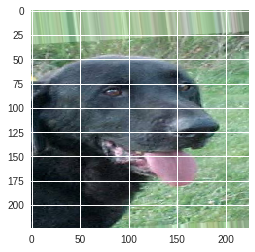

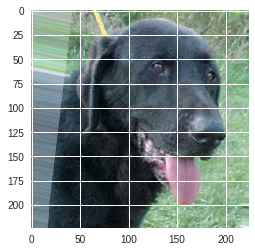

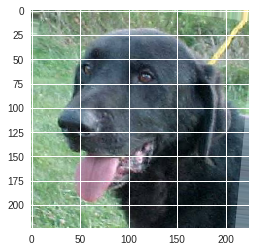

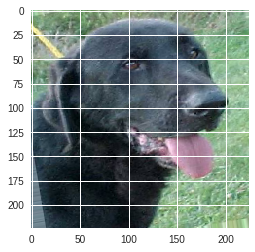

In [0]:
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

Генератор данных для обучения на основе изображений из каталога

In [0]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 0 images belonging to 0 classes.


Смотрим номера классов

In [0]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

## Загружаем предварительно обученную нейронную сеть VGG16

In [0]:
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)

"Замораживаем" веса предварительно обученной нейронной сети VGG16

In [0]:
vgg16_net.trainable = False

In [0]:
vgg16_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Создаем составную нейронную сеть на основе VGG16


In [0]:
model = Sequential()
# Добавляем в модель сеть VGG16 вместо слоя
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


Компилируем составную нейронную сеть

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

## Обучаем сеть с помощью генераторов

In [0]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    verbose=1)

Epoch 1/10
100/100 [==============================] - 98s 977ms/step - loss: 0.6259 - acc: 0.6502
Epoch 2/10
100/100 [==============================] - 89s 893ms/step - loss: 0.4414 - acc: 0.8044
Epoch 3/10
100/100 [==============================] - 93s 927ms/step - loss: 0.3782 - acc: 0.8356
Epoch 4/10
100/100 [==============================] - 93s 933ms/step - loss: 0.3463 - acc: 0.8500
Epoch 5/10
100/100 [==============================] - 93s 935ms/step - loss: 0.3213 - acc: 0.8628
Epoch 6/10
 75/100 [=====================>........] - ETA: 23s - loss: 0.3033 - acc: 0.8725

KeyboardInterrupt: ignored

## Распознаем данные

In [0]:
# Каталог с данными для распознавания
test_dir = 'predict'
# Количество элементов данных для распознавания
nb_test_samples = 1000

Данные для распознавания должны находится в подкаталоге. Поэтому копируем каталог `test` в каталог `predict`

In [0]:
!mkdir predict

In [0]:
!mv test predict

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

Found 1000 images belonging to 1 classes.


In [0]:
test_generator.reset()

In [0]:
predictions = model.predict_generator(test_generator, steps = nb_test_samples // batch_size)

In [0]:
predictions[:5]

array([[0.13361636],
       [0.99015886],
       [0.958959  ],
       [0.7780667 ],
       [0.8585443 ]], dtype=float32)

## Готовим файл с решением для Kaggle

Готовим список имен файлов

In [0]:
filenames_with_dir = test_generator.filenames
filenames_with_dir[:5]

['test/0.jpg', 'test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/101.jpg']

In [0]:
filenames = []
for filename in filenames_with_dir:
    filenames.append(filename.replace('test/',''))
filenames[:5]

['0.jpg', '1.jpg', '10.jpg', '100.jpg', '101.jpg']

Готовим список правильных ответов

In [0]:
threshold = 0.5

In [0]:
binary_predictions = []
for prediction in predictions:
    if prediction >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)      

In [0]:
binary_predictions[:10]

[0, 1, 1, 1, 1, 0, 0, 1, 0, 0]

In [0]:
out = np.column_stack((filenames, binary_predictions))

In [0]:
out[:5]

array([['0.jpg', '0'],
       ['1.jpg', '1'],
       ['10.jpg', '1'],
       ['100.jpg', '1'],
       ['101.jpg', '1']], dtype='<U21')

Записываем результаты в файл

In [0]:
np.savetxt('submission.csv', out, header="filename,label", 
            comments="", fmt="%s,%s")

In [0]:
!head submission.csv

filename,label
0.jpg,0
1.jpg,1
10.jpg,1
100.jpg,1
101.jpg,1
102.jpg,0
103.jpg,0
104.jpg,1
105.jpg,0


Отправляем решение

In [0]:
!kaggle competitions submit -c nu-cats-and-dogs-spring2019 -m "Baseline submition from Colab" -f submission.csv

100% 9.67k/9.67k [00:05<00:00, 1.96kB/s]
Successfully submitted to Распознавание котов и собак на изображениях

Сохраняем решение на свой компьютер

In [0]:
files.download('submission.csv')